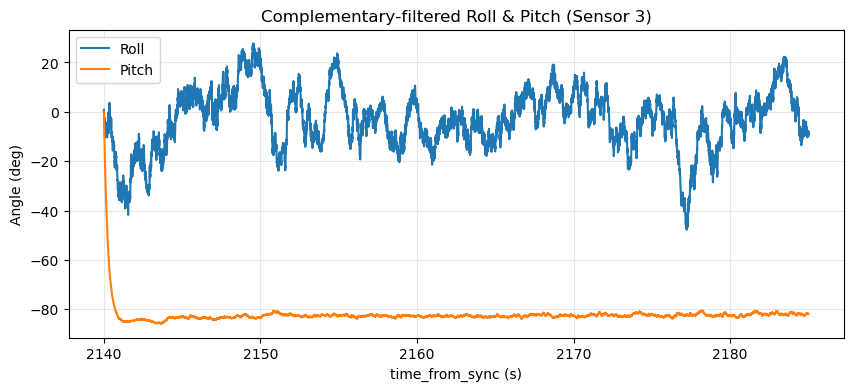

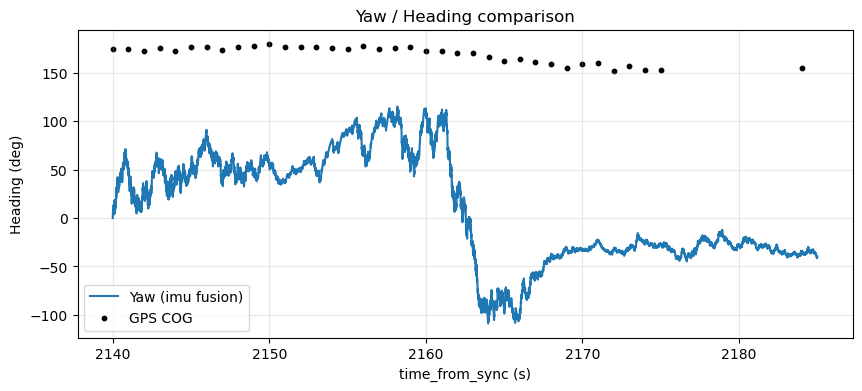

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, math

# --- Load data ---------------------------------------------------------------
gps  = pd.read_csv('./GPS/GPS_021_Quarter_turn_port.csv')
acc  = pd.read_csv('./IMU/Sensor_3/accel_021_Quarter_turn_port.csv')
gyr  = pd.read_csv('./IMU/Sensor_3/gyro_021_Quarter_turn_port.csv')
mag  = pd.read_csv('./IMU/Sensor_3/mag_021_Quarter_turn_port.csv')

# ensure sorted
for df in (gps, acc, gyr, mag):
    df.sort_values('time_from_sync', inplace=True)

# --- Basic calibration -------------------------------------------------------
# Remove hard‑iron offset from magnetometer (centre the cloud)
for axis in ['x', 'y', 'z']:
    mag[axis] = mag[axis] - mag[axis].mean()

# --- Merge IMU streams on their common time base ----------------------------
imu = acc[['time_from_sync','x','y','z']].copy()
imu.rename(columns={'x':'ax','y':'ay','z':'az'}, inplace=True)
imu = imu.merge(gyr[['time_from_sync','x','y','z']].rename(columns={'x':'gx','y':'gy','z':'gz'}),
                on='time_from_sync')
imu = imu.merge(mag[['time_from_sync','x','y','z']].rename(columns={'x':'mx','y':'my','z':'mz'}),
                on='time_from_sync')

# --- Complementary filter parameters ---------------------------------------
dt = imu['time_from_sync'].diff().fillna(method='bfill').values      # seconds
alpha = 0.98         # high weight on gyro (tune 0.95‑0.99)
beta  = 0.98

# allocate outputs
roll  = np.zeros(len(imu))
pitch = np.zeros(len(imu))
yaw   = np.zeros(len(imu))

# --- Helper functions -------------------------------------------------------
def wrap(angle):
    """wrap to ±π"""
    return (angle + np.pi) % (2*np.pi) - np.pi

# --- Filter loop ------------------------------------------------------------
for k in range(1, len(imu)):
    # Gyro rates (convert to rad/s if needed – assume units = deg/s)
    gx, gy, gz = np.deg2rad(imu.loc[k, ['gx','gy','gz']])

    # integrate gyro
    roll_g  = roll[k-1]  + gx*dt[k]
    pitch_g = pitch[k-1] + gy*dt[k]
    yaw_g   = yaw[k-1]   + gz*dt[k]

    # roll/pitch from accelerometer
    ax, ay, az = imu.loc[k, ['ax','ay','az']]
    roll_a  = math.atan2(ay, az)
    pitch_a = math.atan2(-ax, np.sqrt(ay*ay + az*az))

    # tilt‑compensated magnetometer yaw
    mx, my, mz = imu.loc[k, ['mx','my','mz']]
    # rotate mag into horizontal plane
    mx_h = mx*np.cos(pitch_a) + mz*np.sin(pitch_a)
    my_h = mx*np.sin(roll_a)*np.sin(pitch_a) + my*np.cos(roll_a) - mz*np.sin(roll_a)*np.cos(pitch_a)
    yaw_m = math.atan2(-my_h, mx_h)

    # complementary blend
    roll[k]  = alpha*roll_g  + (1-alpha)*roll_a
    pitch[k] = alpha*pitch_g + (1-alpha)*pitch_a
    yaw[k]   = beta*yaw_g    + (1-beta)*yaw_m
    yaw[k]   = wrap(yaw[k])

imu['roll_deg']  = np.rad2deg(roll)
imu['pitch_deg'] = np.rad2deg(pitch)
imu['yaw_deg']   = np.rad2deg(yaw)

# --- Derive GPS course‑over‑ground (heading) -------------------------------
def haversine_angle(lat1, lon1, lat2, lon2):
    # returns heading in radians from point1→point2
    dlon = np.deg2rad(lon2 - lon1)
    dlat = np.deg2rad(lat2 - lat1)
    y = np.sin(dlon)*np.cos(np.deg2rad(lat2))
    x = np.cos(np.deg2rad(lat1))*np.sin(np.deg2rad(lat2)) - np.sin(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2))*np.cos(dlon)
    return np.arctan2(y, x)

gps = gps.copy()
gps['course_rad'] = haversine_angle(gps['Lat'].shift(), gps['Lng'].shift(),
                                    gps['Lat'], gps['Lng'])
gps['course_rad'] = gps['course_rad'].fillna(method='bfill')
gps['course_deg'] = np.rad2deg(gps['course_rad'])
gps['time_from_sync'] = gps['time_from_sync']

# --- Plot orientation estimates --------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(imu['time_from_sync'], imu['roll_deg'], label='Roll')
plt.plot(imu['time_from_sync'], imu['pitch_deg'], label='Pitch')
plt.ylabel('Angle (deg)')
plt.xlabel('time_from_sync (s)')
plt.title('Complementary‑filtered Roll & Pitch (Sensor 3)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(10,4))
plt.plot(imu['time_from_sync'], imu['yaw_deg'], label='Yaw (imu fusion)')
plt.scatter(gps['time_from_sync'], gps['course_deg'], color='k', s=10, label='GPS COG')
plt.ylabel('Heading (deg)')
plt.xlabel('time_from_sync (s)')
plt.title('Yaw / Heading comparison')
plt.legend(); plt.grid(alpha=0.3); plt.show()

# --- Show snapshot table of orientation statistics -------------------------
ori_stats = imu[['roll_deg','pitch_deg','yaw_deg']].describe().loc[['mean','std','min','max']]


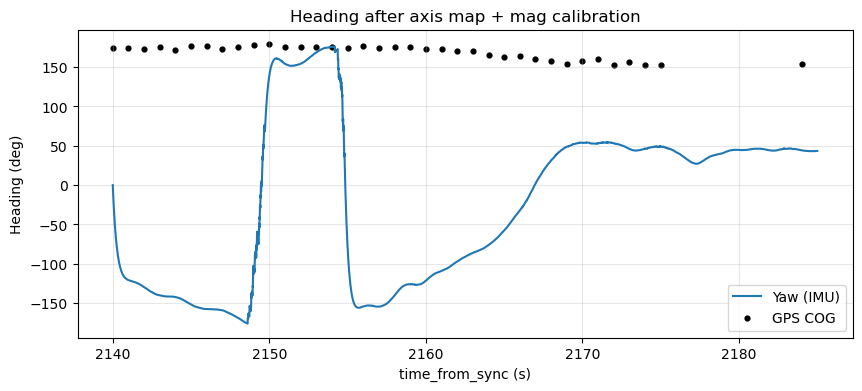

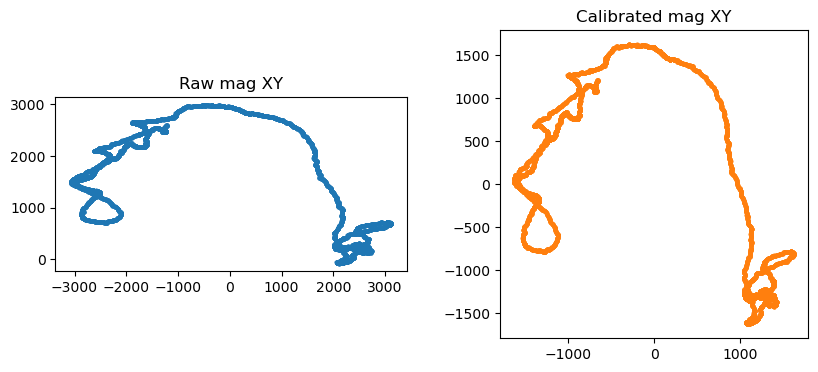

In [4]:
# --- SET-UP ---------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# adjust the filenames if yours differ
gps  = pd.read_csv('./GPS/GPS_021_Quarter_turn_port.csv')
acc  = pd.read_csv('./IMU/Sensor_3/accel_021_Quarter_turn_port.csv')
gyr  = pd.read_csv('./IMU/Sensor_3/gyro_021_Quarter_turn_port.csv')
mag  = pd.read_csv('./IMU/Sensor_3/mag_021_Quarter_turn_port.csv')

for df in (gps, acc, gyr, mag):
    df.sort_values('time_from_sync', inplace=True, ignore_index=True)

# --- 1. AXIS MAP (sensor-3 → body: x=FWD, y=PORT, z=UP) -------------------
def map_axes(df):
    return pd.DataFrame({
        'time_from_sync': df['time_from_sync'],
        'x': df['y'],            # forward
        'y': df['z'],            # port  (left)
        'z': df['x']             # up
    })

acc_b = map_axes(acc).rename(columns={'x':'ax','y':'ay','z':'az'})
gyr_b = map_axes(gyr).rename(columns={'x':'gx','y':'gy','z':'gz'})
mag_b = map_axes(mag).rename(columns={'x':'mx_raw','y':'my_raw','z':'mz_raw'})

# --- 2. MIN-MAX ELLIPSOID CAL ---------------------------------------------
cal = {}
for axis in ['mx_raw','my_raw','mz_raw']:
    mn, mx = mag_b[axis].min(), mag_b[axis].max()
    cal[axis + '_offset'] = (mx + mn) / 2.0
    cal[axis + '_scale']  = (mx - mn) / 2.0          # radius on that axis

r = np.mean([cal[a + '_scale'] for a in ['mx_raw','my_raw','mz_raw']])  # mean radius
for axis in ['mx_raw','my_raw','mz_raw']:
    mag_b[axis.replace('_raw','')] = (mag_b[axis] - cal[axis+'_offset']) * \
                                     (r / cal[axis+'_scale'])

# --- 3. MERGE & COMPLEMENTARY FILTER --------------------------------------
imu = acc_b.merge(gyr_b, on='time_from_sync') \
           .merge(mag_b[['time_from_sync','mx','my','mz']], on='time_from_sync')

dt   = imu['time_from_sync'].diff().fillna(method='bfill').to_numpy()
gyro = np.deg2rad(imu[['gx','gy','gz']].to_numpy())  # rad s⁻¹
acc  = imu[['ax','ay','az']].to_numpy()
mag  = imu[['mx','my','mz']].to_numpy()

α = 0.98                                # gyro weight
N = len(imu)
roll = np.zeros(N);  pitch = np.zeros(N);  yaw = np.zeros(N)

def wrap(a): return (a + np.pi) % (2*np.pi) - np.pi

for k in range(1, N):
    gx, gy, gz = gyro[k]

    # --- integrate gyro (body frame x=fwd, y=port, z=up) -----------------
    roll_g  = roll[k-1]  + (gx + np.sin(roll[k-1])*np.tan(pitch[k-1])*gy +
                            np.cos(roll[k-1])*np.tan(pitch[k-1])*gz) * dt[k]
    pitch_g = pitch[k-1] + (np.cos(roll[k-1])*gy - np.sin(roll[k-1])*gz) * dt[k]
    yaw_g   = yaw[k-1]   + (np.sin(roll[k-1])/np.cos(pitch[k-1])*gy +
                            np.cos(roll[k-1])/np.cos(pitch[k-1])*gz) * dt[k]

    # --- acc tilt --------------------------------------------------------
    ax, ay, az = acc[k]
    roll_a  = np.arctan2( ay,  az)
    pitch_a = np.arctan2(-ax, np.sqrt(ay*ay + az*az))

    # --- tilt-comp mag ---------------------------------------------------
    mx, my, mz = mag[k]
    mx_h = mx*np.cos(pitch_a) + mz*np.sin(pitch_a)
    my_h = mx*np.sin(roll_a)*np.sin(pitch_a) + my*np.cos(roll_a) - \
           mz*np.sin(roll_a)*np.cos(pitch_a)
    yaw_m = np.arctan2(-my_h, mx_h)

    # --- blend -----------------------------------------------------------
    roll[k]  = α*roll_g  + (1-α)*roll_a
    pitch[k] = α*pitch_g + (1-α)*pitch_a
    yaw[k]   = α*yaw_g   + (1-α)*yaw_m
    yaw[k]   = wrap(yaw[k])

imu['roll_deg']  = np.rad2deg(roll)
imu['pitch_deg'] = np.rad2deg(pitch)
imu['yaw_deg']   = np.rad2deg(yaw)

# --- 4. GPS course-over-ground -------------------------------------------
def heading(lat1, lon1, lat2, lon2):
    dL = np.deg2rad(lon2 - lon1)
    lat1 = np.deg2rad(lat1); lat2 = np.deg2rad(lat2)
    y = np.sin(dL)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dL)
    return np.arctan2(y, x)

gps['course_rad'] = heading(gps['Lat'].shift(), gps['Lng'].shift(),
                            gps['Lat'], gps['Lng']).fillna(method='bfill')
gps['course_deg'] = np.rad2deg(gps['course_rad'])

# --- 5. PLOTS -------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(imu['time_from_sync'], imu['yaw_deg'], label='Yaw (IMU)')
plt.scatter(gps['time_from_sync'], gps['course_deg'],
            c='k', s=12, label='GPS COG')
plt.ylabel('Heading (deg)'); plt.xlabel('time_from_sync (s)')
plt.title('Heading after axis map + mag calibration')
plt.grid(alpha=0.3); plt.legend(); plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(mag_b['mx_raw'], mag_b['my_raw'], s=4)
ax[0].set_title('Raw mag XY'); ax[0].set_aspect('equal')
ax[1].scatter(mag_b['mx'], mag_b['my'], s=4, color='tab:orange')
ax[1].set_title('Calibrated mag XY'); ax[1].set_aspect('equal')
plt.show()
